In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import sys
import tqdm

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

Here we produce a BBH mass distribution following 
$$
\frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} m_2} \propto \frac{1}{m_1} \frac{1}{m_1 - M_\mathrm{min}},
$$
that is 
$$
p\left( m_1 \right) \propto \frac{1}{m_1},
$$
and
$$
p\left( m_2 \mid m_1 \right) \propto \mathrm{const}
$$
with $5 \, M_\odot \leq m_2 \leq m_1 \leq 50 \, M_\odot$ and calculate the population-averaged $P_\mathrm{det}(z)$:

In [19]:
Nm = 10
Nz = 100

m1s = logspace(log10(5), log10(50), Nm)
zs = expm1(linspace(log(1), log(3), Nz))

pdets = []
with tqdm.tqdm(total=Nm*Nm) as bar:
    for m1 in m1s:
        for m2 in linspace(5, m1, Nm):
            pdets.append(array([vt.fraction_above_threshold(m1, m2, z, 8, vt.ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044) for z in zs]))
            bar.update(1)
pdets = array(pdets)

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Text(0, 0.5, '$P_\\mathrm{det} \\left( z \\mid m_1, m_2 \\right)$')

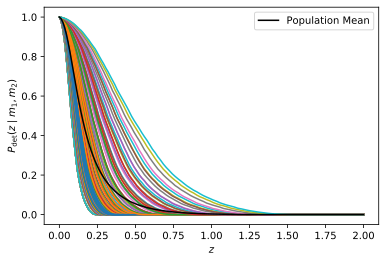

In [20]:
for pd in pdets:
    plot(zs, pd)
plot(zs, mean(pdets, axis=0), '-k', label='Population Mean')
legend(loc='best')
xlabel(r'$z$')
ylabel(r'$P_\mathrm{det} \left( z \mid m_1, m_2 \right)$')

Text(0, 0.5, '$n_\\mathrm{BBH}$ ($\\mathrm{Gpc}^{-3}$)')

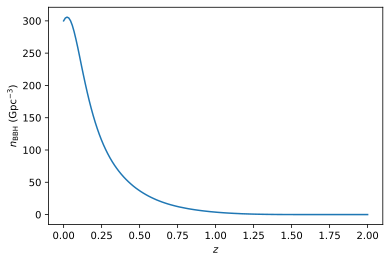

In [21]:
R0 = 60 # Gpc^-3 yr^-1
T = 5 # yr
obs_bbh_density = mean(pdets, axis=0)*R0*T*(1+zs)**2 # Gpc^-3

plot(zs, obs_bbh_density)
xlabel(r'$z$')
ylabel(r'$n_\mathrm{BBH}$ ($\mathrm{Gpc}^{-3}$)')

In [22]:
trapz(4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*obs_bbh_density, zs)

4321.442148195514

The surveyed volume at wavenumber $k$ is then 
$$
V(k) = \int \mathrm{d} z \frac{n_\mathrm{BBH}(z) P(k)}{1 + n_\mathrm{BBH}(z) P(k)} \frac{\mathrm{d} V}{\mathrm{d} z}
$$

The below numbers are from [Eisenstein, et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005ApJ...633..560E/abstract).

In [23]:
h = 0.7
h3 = h*h*h

k15 = 0.15*h # 1/Mpc
P15 = 1e4/h3/1e9 # Gpc^3

k05 = 0.05*h # 1/Mpc
P05 = 4e4/h3/1e9 # Gpc^3

k02 = 0.02*h # 1/Mpc
P02 = 1e5/h3/1e9 # Gpc^3

In [24]:
V15 = trapz(obs_bbh_density*P15 / (1 + obs_bbh_density*P15) * 4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value, zs)
V05 = trapz(obs_bbh_density*P05 / (1 + obs_bbh_density*P05) * 4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value, zs)
V02 = trapz(obs_bbh_density*P02 / (1 + obs_bbh_density*P02) * 4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value, zs)

In [25]:
print('At k = {:.2f} h / Mpc, SDSS had {:.2f} Gpc^3; we have {:.2f} Gpc^3'.format(k15/h, 0.13/h3, V15))
print('At k = {:.2f} h / Mpc, SDSS had {:.2f} Gpc^3; we have {:.2f} Gpc^3'.format(k05/h, 0.38/h3, V05))
print('At k = {:.2f} h / Mpc, SDSS had {:.2f} Gpc^3; we have {:.2f} Gpc^3'.format(k02/h, 0.55/h3, V02))

At k = 0.15 h / Mpc, SDSS had 0.38 Gpc^3; we have 0.13 Gpc^3
At k = 0.05 h / Mpc, SDSS had 1.11 Gpc^3; we have 0.50 Gpc^3
At k = 0.02 h / Mpc, SDSS had 1.60 Gpc^3; we have 1.24 Gpc^3
